In [1]:
import os
os.chdir("../../")

In [2]:
import scanpy as sc
import surgeon
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import pandas as pd

Using TensorFlow backend.
/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mohsen/miniconda3

In [13]:
adata = sc.read("./data/panorama/panorama_normalized.h5ad")
adata

AnnData object with n_obs × n_vars = 24552 × 2000 
    obs: 'batch', 'cell_type', 'study', 'n_counts', 'size_factors'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

In [15]:
adata.obs['cell_type'].value_counts()

Macrophage                  6596
PBMC T cells                3576
PBMC CD4 T cells            2140
Jurkat                      1846
Neuron                      1806
PBMC CD56+ NK               1390
PBMC CD14+ monocyte          999
Pancreas Alpha               971
Pancreas Beta                936
293t                         896
PBMC CD8 T cells             798
PBMC CD19+ B cells           690
Pancreas Ductal              389
Hsc MEP                      260
Hsc GMP                      237
Pancreas Delta               233
Pancreas Endothelial         161
Pancreas Acinar              136
Hsc CMP                      135
Pancreas Gamma               120
Pancreas Stellate            114
Pancreas Unkonwn              61
Pancreas Beta(ER stress)      60
Hsc Unknown                    2
Name: cell_type, dtype: int64

In [14]:
adata.obs.groupby(['study', 'cell_type']).size()

study                   cell_type               
293t                    293t                         577
B Cells                 PBMC CD19+ B cells           452
CD4 T Helper            PBMC CD4 T cells             742
CD14 Monocytes          PBMC CD14+ monocyte           59
CD56 NK                 PBMC CD56+ NK               1331
Cytotoxic T Cells       PBMC CD8 T cells             798
HSC Mars                Hsc CMP                       63
                        Hsc GMP                      217
                        Hsc MEP                      200
HSC SS2                 Hsc CMP                       72
                        Hsc GMP                       20
                        Hsc MEP                       60
                        Hsc Unknown                    2
Jurkat                  Jurkat                       651
Jurkat 293t 50:50       293t                         319
                        Jurkat                       358
Jurkat 293t 99:1        Jurkat         

In [35]:
sc.read("./results/classification/predictions-1-mse.h5ad").obs['study'].value_counts()

PBMC 68K            3601
Pancreas inDrop     1713
Jurkat               651
Macrophage Mixed     434
Name: study, dtype: int64

In [36]:
results_df = sc.read("./results/classification/predictions-1-mse.h5ad").obs

In [37]:
true_labels = results_df['cell_type']
pred_labels = results_df['predicted_TF']
pred_sc_labels = results_df['predicted_scratch']
knn_labels = results_df['predicted_KNN']

In [38]:
cell_types = results_df['cell_type'].unique().tolist()

In [39]:
cell_type_accuracies = {"MLP - scratch": {}, 
                        "MLP - TF" : {},
                        "KNN": {}}

In [40]:
for cell_type in cell_types:
    cell_type_df = results_df[results_df['cell_type'] == cell_type]
    cell_type_true_labels = true_labels[true_labels == cell_type]
    cell_type_pred_labels_sc = pred_sc_labels[cell_type_true_labels.index]
    cell_type_pred_labels_tf = pred_labels[cell_type_true_labels.index]
    cell_type_pred_labels_knn = knn_labels[cell_type_true_labels.index]
    cell_type_accuracies['MLP - scratch'][cell_type] = accuracy_score(cell_type_true_labels, cell_type_pred_labels_sc)
    cell_type_accuracies['MLP - TF'][cell_type] = accuracy_score(cell_type_true_labels, cell_type_pred_labels_tf)
    cell_type_accuracies['KNN'][cell_type] = accuracy_score(cell_type_true_labels, cell_type_pred_labels_knn)

In [41]:
acc_df = pd.DataFrame({"cell_type": cell_types, "MLP - scratch": list(cell_type_accuracies["MLP - scratch"].values()), "MLP - TF": list(cell_type_accuracies['MLP - TF'].values()), "KNN": list(cell_type_accuracies['KNN'].values())})
acc_df.head()

,cell_type,MLP - scratch,MLP - TF,KNN
0,Jurkat,1.000000,1.000000,0.998464
1,Macrophage,1.000000,1.000000,0.995392
2,Pancreas Beta,0.974638,0.972826,0.847826
3,Pancreas Alpha,1.000000,0.985169,0.938559
4,Pancreas Ductal,0.969697,0.987879,0.878788


In [42]:
plot_acc_df = pd.melt(acc_df, id_vars=['cell_type'], var_name=['Method'], value_name='acc')
plot_acc_df.head()

,cell_type,Method,acc
0,Jurkat,MLP - scratch,1.000000
1,Macrophage,MLP - scratch,1.000000
2,Pancreas Beta,MLP - scratch,0.974638
3,Pancreas Alpha,MLP - scratch,1.000000
4,Pancreas Ductal,MLP - scratch,0.969697


In [44]:
cell_types_to_remove = ['Pancreas Beta', 'Pancreas Alpha', 'Pancreas Beta(ER stress)', 
                        'Pancreas Endothelial', 'Pancreas Unknown', 'PBMC CD56+ NK']

In [45]:
plt_acc_df_subset = plot_acc_df[~plot_acc_df['cell_type'].isin(cell_types_to_remove)]

In [50]:
sns.set

<function seaborn.rcmod.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)>

In [51]:
import matplotlib
font = {'family' : 'Arial',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('ytick', labelsize=22)
matplotlib.rc('xtick', labelsize=22)

<Figure size 1080x360 with 0 Axes>

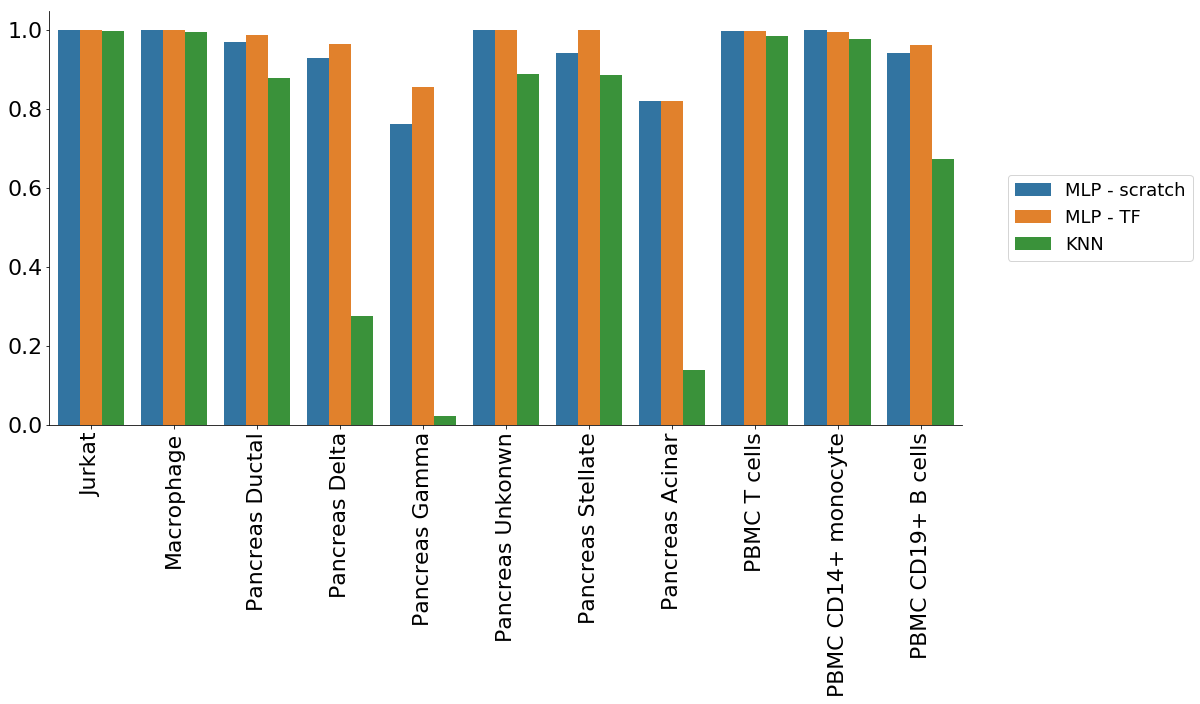

In [52]:
plt.close("all")
plt.figure(figsize=(15, 5))
g = sns.catplot(x="cell_type", y="acc",
                 hue="Method", legend=False,
                 data=plt_acc_df_subset, kind="bar",
                 height=10, aspect=1.7);
plt.xlabel('', fontsize=22)
plt.ylabel("", fontsize=22)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05,0.5), borderaxespad=0, loc='center left', prop={'size': 18})
plt.tight_layout()
plt.savefig("./results/classification/accuracies_barplot.pdf", dpi=300)
plt.show()